In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
df = pd.read_csv('./../../data/processed/ID_Y.csv')
# df = pd.read_csv('./../../data/processed/.csv')

Mbool = 0
sales = df.loc[df.IMPORT == Mbool].groupby(['ID', 'YEAR'])['VART'].sum().unstack()

sales = sales.loc[sales.sum(1).sort_values().index]

logsales = np.log10(sales)
demlogsales = logsales.subtract(logsales.mean(1), axis = 0)

sizes = sales.loc[sales.sum(1).sort_values().index].sum(1)

Q = 10
parts = pd.cut(sizes.cumsum()/sizes.sum(), Q, labels = range(Q)).sort_index()

In [3]:
## Effective Nq
eff_nq = sales.groupby(parts).count().mean(1).round().astype(int)
eff_nq

0    98643
1     4212
2     1414
3      635
4      319
5      168
6       92
7       46
8       17
9        5
dtype: int64

In [4]:
# yqs = sales.groupby(parts).sum()a
# yqs.T.cov().sum().sum()

## Fit to theoretical deduction with "narrow bin" approximation

In [5]:

## Microshocks

demlogsales['parts'] = parts
std_data = demlogsales.loc[demlogsales.iloc[:, :-1].count(1) > 1]
std_data.reset_index().set_index(['ID', 'parts']).stack().groupby(level = 'parts').std()


# Un array de donde samplear shocks empiricos.
emp_shocks = std_data.reset_index().set_index(['ID', 'parts']).stack().values
len(emp_shocks)

1615735

In [6]:
def percentile_lo (x): 
    return np.percentile(x, q=10)
def percentile_hi (x): 
    return np.percentile(x, q=90)

In [7]:
# emp_nqs = np.round(nq.sort_values()).astype(int)
partition = eff_nq.astype(int)
ss = np.arange(0.1, .8, .1)
M = 100

T = 17

In [8]:

### Experiments (gaussian and laplace deviations from mean)

results = []

s0 = emp_shocks.std()

for dist in ['norm', 'lapl', 'emp']:
    for q in range(Q)[1:]:
        part = partition.index[q]
        n = partition.values[q]
#         x0 = np.log10(sizes.loc[parts == part]).values # comment for narrow bin limit
        print(q, n)
        for s in ss:
            for m in range(M):
                if dist == 'norm':
                    shocks = np.random.normal(0, s, (n, T))
                elif dist == 'lapl':
                    shocks = np.random.laplace(0, s, (n, T))/np.sqrt(2)
                elif dist == 'emp':
                    shocks = (np.random.choice(emp_shocks, n * T)*(s/s0)).reshape(n, T)
                    
                values = np.log10(np.power(10, shocks).sum(0)/n) #M?
#                 values = np.log10(np.power(10, x0[:, None] + shocks).sum(0)/np.power(10, x0[:, None]).sum(0)) #M? # comment for narrow bin limit

#             t += [np.power(10, x0 + x1).sum()/(n*10**mu0)]
                results += [[dist, s, n, m, values.mean(), values.std()]]

result = pd.DataFrame(results, columns = ['dist', 's', 'nq', 'repeat', 'mean', 'std'])


1 4212
2 1414
3 635
4 319
5 168
6 92
7 46
8 17
9 5
1 4212
2 1414
3 635
4 319
5 168
6 92
7 46
8 17
9 5
1 4212
2 1414
3 635
4 319
5 168
6 92
7 46
8 17
9 5


### vs micro sigma

/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in log10


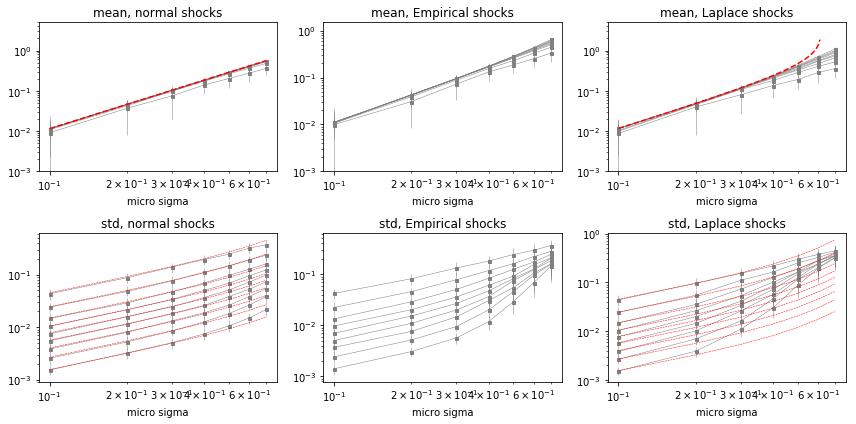

In [19]:

fig, axs = plt.subplots(2, 3, figsize = (12, 6))

#################
# Normal
plot_data = result.loc[result.dist == 'norm'].groupby(['nq','s'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[0][0]
ax.set_title('mean, normal shocks')

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('micro sigma')
    
## Analytical expectation
ax.plot(x, x**2*np.log(10)/2, color = 'r', linestyle = '--', zorder = 10)

###
ax.set_yscale('log')
ax.set_ylim(.001, 5)

ax.set_xscale('log')


#################
ax = axs[1][0]
ax.set_title('std, normal shocks')

# logplot_data = np.log10(plot_data)
y_data = plot_data['std']['mean'].unstack()
yhi_data = plot_data['std']['percentile_hi'].unstack() - plot_data['std']['mean'].unstack()
ylo_data = plot_data['std']['mean'].unstack() - plot_data['std']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('micro sigma')

## Analytical expectation
for n0 in partition.values[1:]:
    ax.plot(x, np.sqrt(np.exp(x**2)*(np.exp(x**2) - 1)/n0), color = 'r', linestyle = '--', zorder = 10, lw = .5)
# for n0 in partition.values[1:]:
#     ax.plot(x, np.sqrt((np.exp(x**2) - 1)/n0), color = 'g', linestyle = '--', zorder = 10, lw = .5)

ax.set_xscale('log')
ax.set_yscale('log')
    
    
#################
# Empirical Shocks
plot_data = result.loc[result.dist == 'emp'].groupby(['nq', 's'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[0][1]
ax.set_title('mean, Empirical shocks')

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
# ax.axvspan(.5, .6, facecolor='.85', alpha=0.5)

ax.set_xlabel('micro sigma')

###
ax.set_yscale('log')
ax.set_ylim(.001, 1.5)
    
ax.set_xscale('log')

#################
    
ax = axs[1][1]
ax.set_title('std, Empirical shocks')

# logplot_data = np.log10(plot_data)
y_data = plot_data['std']['mean'].unstack()
yhi_data = plot_data['std']['percentile_hi'].unstack() - plot_data['std']['mean'].unstack()
ylo_data = plot_data['std']['mean'].unstack() - plot_data['std']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)

# ax.axvspan(.5, .6, facecolor='.85', alpha=0.5)

ax.set_xlabel('micro sigma')

ax.set_xscale('log')
ax.set_yscale('log')


#################
# Laplace
plot_data = result.loc[result.dist == 'lapl'].groupby(['nq','s'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[0][2]
ax.set_title('mean, Laplace shocks')

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('micro sigma')


## Analytical expectation
x = np.arange(x.min(), x.max(), 0.01)
# ax.plot(x, np.log10(1/(1 - (x*np.log(10))**2/2)), color = 'r', linestyle = '--', zorder = 10)
ax.plot(x, np.log10(1/(1 - (x*np.log(10))**2/2)), color = 'r', linestyle = '--', zorder = 10)
# ax.plot(x, (x**2 * np.log(10))/2, color = 'g', linestyle = '--', zorder = 10) # small s approximation

###
ax.set_yscale('log')
ax.set_ylim(.001, 5)

ax.set_xscale('log')


#################
    
ax = axs[1][2]
ax.set_title('std, Laplace shocks')

# logplot_data = np.log10(plot_data)
y_data = plot_data['std']['mean'].unstack()
yhi_data = plot_data['std']['percentile_hi'].unstack() - plot_data['std']['mean'].unstack()
ylo_data = plot_data['std']['mean'].unstack() - plot_data['std']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
    
## Analytical expectation
for n0 in partition.values[1:]:
#     ax.plot(x, np.sqrt(1/n0) * (x/(x**2 - 2)) * np.sqrt((x**2 + 4)/(2*x**2 - 1)), color = 'r', linestyle = '--', zorder = 10, lw = .5)
    ax.plot(x, np.sqrt(1/n0) * (x + 13*x**3/8 + 311*x**5/128) , color = 'r', linestyle = '--', zorder = 10, lw = .5)
    
ax.set_xlabel('micro sigma')

# solo funciona con escala lineal en la horizontal
# plt.xticks(rotation=45, ha='right')
# for tick in ax.get_xticklabels():
#     tick.set_rotation(30)
    
ax.set_xscale('log')
ax.set_yscale('log')



plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/power_sums_vs_sigma_'+str(Mbool)+'.png')
plt.show()

### vs log(nq)

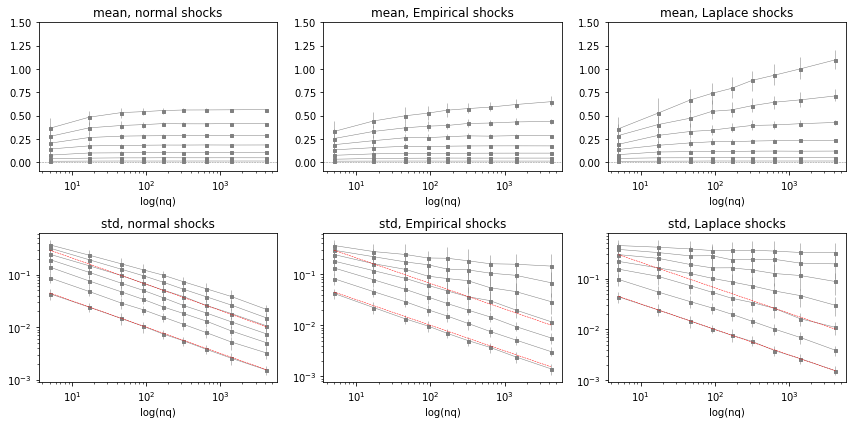

In [20]:

fig, axs = plt.subplots(2, 3, figsize = (12, 6))

#################
# Normal
plot_data = result.loc[result.dist == 'norm'].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[0][0]
ax.set_title('mean, normal shocks')

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('log(nq)')
    
ax.set_xscale('log')
#################
ax = axs[1][0]
ax.set_title('std, normal shocks')

# logplot_data = np.log10(plot_data)
y_data = plot_data['std']['mean'].unstack()
yhi_data = plot_data['std']['percentile_hi'].unstack() - plot_data['std']['mean'].unstack()
ylo_data = plot_data['std']['mean'].unstack() - plot_data['std']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('log(nq)')

ax.set_xscale('log')
ax.set_yscale('log')

for s0 in [0.1, 0.6]:
    ax.plot(x, np.sqrt((np.exp(s0**2) - 1)/x), color = 'r', linestyle = '--', zorder = 10, lw = .5)

#################
# Empirical Shocks
plot_data = result.loc[result.dist == 'emp'].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[0][1]
ax.set_title('mean, Empirical shocks')

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('log(nq)')

ax.set_xscale('log')
#################
    
ax = axs[1][1]
ax.set_title('std, Empirical shocks')

# logplot_data = np.log10(plot_data)
y_data = plot_data['std']['mean'].unstack()
yhi_data = plot_data['std']['percentile_hi'].unstack() - plot_data['std']['mean'].unstack()
ylo_data = plot_data['std']['mean'].unstack() - plot_data['std']['percentile_lo'].unstack()
x = y_data.columns.values
for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('log(nq)')

# sqrt(sobs2 - (strend)2) = (sq)
# ax.plot(np.log10(emp_nq_med), np.log10(np.sqrt(emp_std_mn**2 - np.median(trend_std)**2))) 

ax.set_xscale('log')
ax.set_yscale('log')

for s0 in [0.1, 0.6]:
    ax.plot(x, np.sqrt((np.exp(s0**2) - 1)/x), color = 'r', linestyle = '--', zorder = 10, lw = .5)

#################
# Laplace
plot_data = result.loc[result.dist == 'lapl'].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[0][2]
ax.set_title('mean, Laplace shocks')

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
    
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('log(nq)')
ax.set_xscale('log')

#################
    
ax = axs[1][2]
ax.set_title('std, Laplace shocks')

# logplot_data = np.log10(plot_data)
y_data = plot_data['std']['mean'].unstack()
yhi_data = plot_data['std']['percentile_hi'].unstack() - plot_data['std']['mean'].unstack()
ylo_data = plot_data['std']['mean'].unstack() - plot_data['std']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('log(nq)')
ax.set_xscale('log')
ax.set_yscale('log')

for s0 in [0.1, 0.6]:
    ax.plot(x, np.sqrt((np.exp(s0**2) - 1)/x), color = 'r', linestyle = '--', zorder = 10, lw = .5)

plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/power_sums_vs_nq_'+str(Mbool)+'.png')
    
plt.show()

## Repeat, non narrow bins, i.e. sizes in x0 used

In [21]:
### Proximos testeos: size distribution...

In [22]:
# Para ellos, es todo igual, nomas que hay una distribucion de sizes, los shocks se agregan a ellas y se divide por (X/Q) en vez de (s0*n)

 ### Size distributions

In [23]:
from scipy.stats import norm
from scipy.stats import pareto
from scipy.special import erf

# The size dists are:
#  - Lognormal clipped x > 3. 
sigma = 1.2810683494198207 # 1.3149476902828778
mu = 4.536908110675739 # 4.470439741406725
# 11.5% of guys that would be below the .3 threshold.
z = (mu - 3)/sigma
cum_th = 1 - .5*(1 + erf(z/np.sqrt(2)))

# We'll try different N's, until we can match the avg level of France imports 

N = int(1e5)
N_ = int(round(N/(1 - cum_th))) # We use a larger N ..
draw = np.random.normal(mu, sigma, N_) # so that approximately we'll have N guys above x = 3
draw = np.sort(draw)[-N:]

# Now we can have the n(Q, q)
def get_n(x1, Q):
    x_lin = np.power(10, x1)
    bins = pd.cut(pd.Series(np.cumsum(x_lin)), Q)
    ns = bins.value_counts().values
    return bins, ns

# From the theoretical N and the ppf we can know the theoretical quantiles
x_logn_clip3 = np.array([norm.ppf(q, mu, sigma) for q in np.arange(0, 1, 1/N_) + .5/N_])
x_logn_clip3 = x_logn_clip3[(-N - 1):-1]

## N tail for pareto and lognormal tail
N_tail = get_n(x_logn_clip3, 10)[1][1:].sum()

n = N_tail
x_logn_clip3_90 = x_logn_clip3[-N_tail:]

# PARETO
z_0 = -1.1042021 #-1.1771
# value_qs_1 = x_logn_clip3_90.min() # 6.761 in the original fit
value_qs_1 = 6.67465

norm = 1.375
x1 = np.array([pareto.ppf(b = -z_0, scale = 10**value_qs_1, q = q) for q in np.arange(0, 1, 1/(norm*N_tail)) + .5/(norm*N_tail)])
np.log10(pareto.rvs(b = -z_0, size = n, scale = 10**value_qs_1) + 1)
x1 = x1[int(-norm*N_tail - 1):-1]

x_pareto = np.log10(x1)

In [24]:
# emp_nqs = np.round(nq.sort_values()).astype(int)
ss = np.arange(0.1, .8, .2)
M = 100

T = 17

In [25]:
### Experiments (gaussian and laplace deviations from mean)

results = []


for dist in ['norm', 'lapl']:
    for j, size_dist in enumerate([x_logn_clip3, x_logn_clip3_90, x_pareto]):
        print('*')
        sdist_name = ['Logn', 'Logn90', 'Pareto'][j]
        bins, partition_ns = get_n(size_dist, Q)
        for q, part in enumerate(bins.unique()):
            x0 = pd.Series(size_dist).loc[bins == part].values
            n = partition_ns[q]
            for s in ss:
                for m in range(M):
                    if dist == 'norm':
                        shocks = np.random.normal(0, s, (n, T))
                    elif dist == 'lapl':
                        shocks = np.random.laplace(0, s, (n, T))/np.sqrt(2)
    #                 values = np.log10(np.power(10, shocks).sum(0)/n) #M?
                    # same as before but now x0 is a vector of sizes in the quantile, determined by the size dist, N and the Q chosen.
                    values = np.log10(np.power(10, x0[:, None] + shocks).sum(0)/np.power(10, x0[:, None]).sum(0)) #M?
    #             t += [np.power(10, x0 + x1).sum()/(n*10**mu0)]


                    results += [[dist, sdist_name, s, n, m, values.mean(), values.std()]]

sdist_result = pd.DataFrame(results, columns = ['dist', 'size_dist', 's', 'nq', 'repeat', 'mean', 'std'])


*
*
*
*
*
*


/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log10
/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in log10


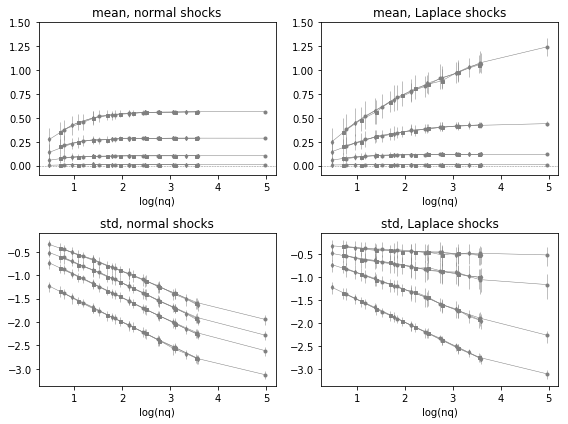

In [26]:

fig, axs = plt.subplots(2, 2, figsize = (8, 6))

#################
# Normal
ax = axs[0][0]
ax.set_title('mean, normal shocks')

for i, sdist in enumerate(['Logn', 'Logn90', 'Pareto']):
    marker = ['o', 's', 'd'][i]
    plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'norm')].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    
    y_data = plot_data['mean']['mean'].unstack()
    yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
    ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
    x = np.log10(y_data.columns.values)

    for s in y_data.index.values:
        ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = marker, markersize = 3)
    
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('log(nq)')
    
# #################
ax = axs[1][0]
ax.set_title('std, normal shocks')

for i, sdist in enumerate(['Logn', 'Logn90', 'Pareto']):
    marker = ['o', 's', 'd'][i]
    plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'norm')].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    logplot_data = np.log10(plot_data)
    y_data = logplot_data['std']['mean'].unstack()
    yhi_data = logplot_data['std']['percentile_hi'].unstack() - logplot_data['std']['mean'].unstack()
    ylo_data = logplot_data['std']['mean'].unstack() - logplot_data['std']['percentile_lo'].unstack()
    x = np.log10(y_data.columns.values)

    for s in y_data.index.values:
        ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = marker, markersize = 3)
ax.set_xlabel('log(nq)')

# # Empirical
# ax.fill_between(np.log10(emp_nq_med), np.log10(emp_std_hi), np.log10(emp_std_lo), color = '#1f77b4', alpha = .25, label = 'empirical')
# ax.plot(np.log10(emp_nq_med), np.log10(emp_std_mn), marker = '*', label = 'mu_q', color = 'g', lw = 0)

# #################
# # Laplace

ax = axs[0][1]
ax.set_title('mean, Laplace shocks')

for i, sdist in enumerate(['Logn', 'Logn90', 'Pareto']):
    marker = ['o', 's', 'd'][i]
    plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'lapl')].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    
    y_data = plot_data['mean']['mean'].unstack()
    yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
    ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
    x = np.log10(y_data.columns.values)

    for s in y_data.index.values:
        ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = marker, markersize = 3)

ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('log(nq)')
    
# # Empirical
# ax.fill_between(np.log10(emp_nq_med), emp_mean_hi, emp_mean_lo, color = '#1f77b4', alpha = .25, label = 'empirical')
# ax.plot(np.log10(emp_nq_med), emp_mean_mn, marker = '*', label = 'mu_q', color = 'g', lw = 0)

# #################
    
ax = axs[1][1]
ax.set_title('std, Laplace shocks')

for i, sdist in enumerate(['Logn', 'Logn90', 'Pareto']):
    marker = ['o', 's', 'd'][i]
    plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'lapl')].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    logplot_data = np.log10(plot_data)
    y_data = logplot_data['std']['mean'].unstack()
    yhi_data = logplot_data['std']['percentile_hi'].unstack() - logplot_data['std']['mean'].unstack()
    ylo_data = logplot_data['std']['mean'].unstack() - logplot_data['std']['percentile_lo'].unstack()
    x = np.log10(y_data.columns.values)

    for s in y_data.index.values:
        ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = marker, markersize = 3)
ax.set_xlabel('log(nq)')

# # Empirical
# ax.fill_between(np.log10(emp_nq_med), np.log10(emp_std_hi), np.log10(emp_std_lo), color = '#1f77b4', alpha = .25, label = 'empirical')
# ax.plot(np.log10(emp_nq_med), np.log10(emp_std_mn), marker = '*', label = 'mu_q', color = 'g', lw = 0)
plt.tight_layout()

plt.savefig('./../../../WRITING/FIGURES/trade/size_dist_nqtest_'+str(Mbool)+'.png')
plt.show()

/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10
/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in log10


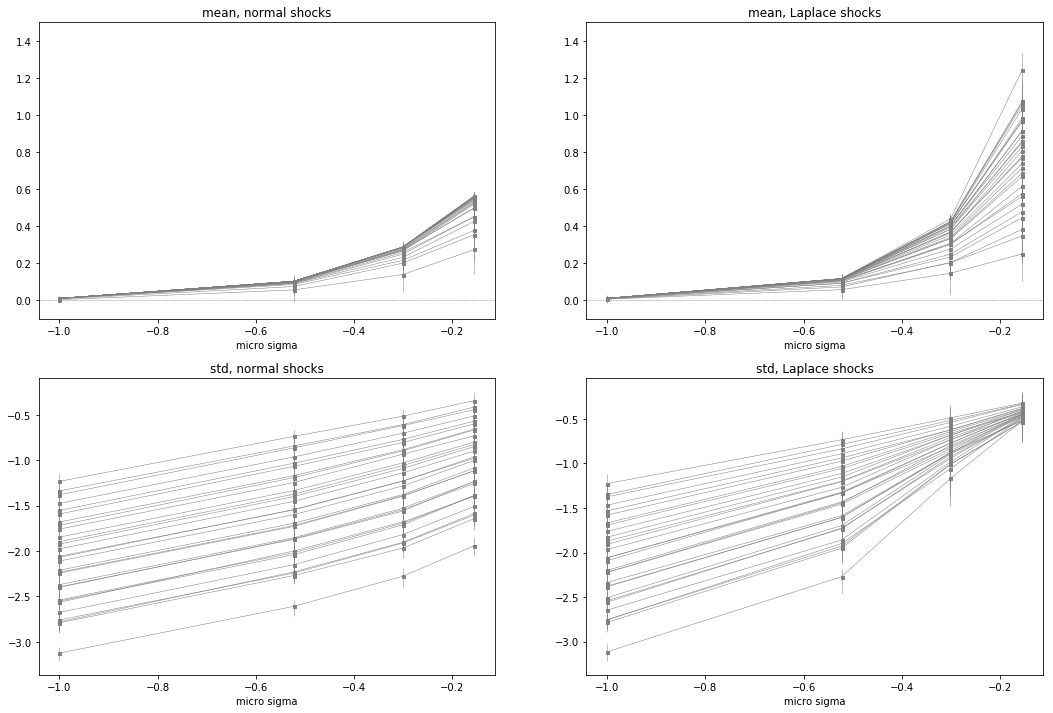

In [27]:

fig, axs = plt.subplots(2, 2, figsize = (18, 12))

#################
# Normal
ax = axs[0][0]
ax.set_title('mean, normal shocks')

for sdist in ['Logn', 'Logn90', 'Pareto']:
    plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'norm')].groupby(['nq', 's'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    
    y_data = plot_data['mean']['mean'].unstack()
    yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
    ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
    x = np.log10(y_data.columns.values)

    for s in y_data.index.values:
        ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
    
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('micro sigma')
    
# #################
ax = axs[1][0]
ax.set_title('std, normal shocks')

for sdist in ['Logn', 'Logn90', 'Pareto']:
    plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'norm')].groupby(['nq', 's'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    logplot_data = np.log10(plot_data)
    y_data = logplot_data['std']['mean'].unstack()
    yhi_data = logplot_data['std']['percentile_hi'].unstack() - logplot_data['std']['mean'].unstack()
    ylo_data = logplot_data['std']['mean'].unstack() - logplot_data['std']['percentile_lo'].unstack()
    x = np.log10(y_data.columns.values)

    for s in y_data.index.values:
        ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('micro sigma')

# # Empirical
# ax.fill_between(np.log10(emp_nq_med), np.log10(emp_std_hi), np.log10(emp_std_lo), color = '#1f77b4', alpha = .25, label = 'empirical')
# ax.plot(np.log10(emp_nq_med), np.log10(emp_std_mn), marker = '*', label = 'mu_q', color = 'g', lw = 0)

# #################
# # Laplace

ax = axs[0][1]
ax.set_title('mean, Laplace shocks')

for sdist in ['Logn', 'Logn90', 'Pareto']:
    plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'lapl')].groupby(['nq', 's'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    
    y_data = plot_data['mean']['mean'].unstack()
    yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
    ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
    x = np.log10(y_data.columns.values)

    for s in y_data.index.values:
        ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)

ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('micro sigma')
    
# # Empirical
# ax.fill_between(np.log10(emp_nq_med), emp_mean_hi, emp_mean_lo, color = '#1f77b4', alpha = .25, label = 'empirical')
# ax.plot(np.log10(emp_nq_med), emp_mean_mn, marker = '*', label = 'mu_q', color = 'g', lw = 0)

# #################
    
ax = axs[1][1]
ax.set_title('std, Laplace shocks')

for sdist in ['Logn', 'Logn90', 'Pareto']:
    plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'lapl')].groupby(['nq', 's'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    logplot_data = np.log10(plot_data)
    y_data = logplot_data['std']['mean'].unstack()
    yhi_data = logplot_data['std']['percentile_hi'].unstack() - logplot_data['std']['mean'].unstack()
    ylo_data = logplot_data['std']['mean'].unstack() - logplot_data['std']['percentile_lo'].unstack()
    x = np.log10(y_data.columns.values)

    for s in y_data.index.values:
        ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('micro sigma')

# # Empirical
# ax.fill_between(np.log10(emp_nq_med), np.log10(emp_std_hi), np.log10(emp_std_lo), color = '#1f77b4', alpha = .25, label = 'empirical')
# ax.plot(np.log10(emp_nq_med), np.log10(emp_std_mn), marker = '*', label = 'mu_q', color = 'g', lw = 0)
plt.savefig('./../../../WRITING/FIGURES/trade/size_dist_s_test_'+str(Mbool)+'.png')

plt.show()